In [3]:
# Set CUDA_LAUNCH_BLOCKING for detailed debugging
%env CUDA_LAUNCH_BLOCKING=1

import torch
import torch.nn as nn
import pandas as pd
from transformers import DebertaV2Tokenizer, DebertaV2Model, pipeline
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.metrics import f1_score, accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess dataset
data = pd.read_csv("/kaggle/input/tweet-data-game-on/Updated_Tweet_Data.csv")
data = data[data['Content'] != "Error: Tweet could not be scraped"]
data = data.dropna(subset=['Content']).reset_index(drop=True)

# Initialize DeBERTaV3 Tokenizer and RoBERTa fake news pipeline
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")
clf = pipeline("text-classification", model="winterForestStump/Roberta-fake-news-detector", tokenizer="winterForestStump/Roberta-fake-news-detector")
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define Text Encoder (DeBERTaV3 Large)
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-large")
        self.proj = nn.Linear(1024, 512) 

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.proj(outputs[:, 0, :]) 

# Define Image Encoder (DenseNet-121)
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj = nn.Linear(1024, 512)

    def forward(self, images):
        features = self.features(images)
        pooled = self.avgpool(features).view(features.size(0), -1)
        return self.proj(pooled)  

# Multimodal Model with Transformer Encoder for Fusion
class MultimodalTransformerModel(nn.Module):
    def __init__(self, hidden_dim=512, output_dim=4):
        super(MultimodalTransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text_features, image_features):
        combined_features = torch.stack([text_features, image_features], dim=1)
        fused_features = self.transformer_encoder(combined_features).mean(dim=1)
        return self.classifier(fused_features)

# Preprocessing functions
def preprocess_text(text):
    encoding = tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

def preprocess_image(image_name):
    if pd.isna(image_name) or not isinstance(image_name, str):
        return torch.zeros(3, 224, 224)
    image_path = os.path.join("/kaggle/input/tweet-data-game-on/Tweet_Images/", image_name)
    try:
        image = Image.open(image_path).convert("RGB")
        return image_transform(image)
    except FileNotFoundError:
        return torch.zeros(3, 224, 224)

# Dataset and Dataloader
class EvalitaDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text_input, attention_mask = preprocess_text(row["Content"])
        image_input = preprocess_image(row.get("Image_Name", None))
        label = torch.tensor(row["Label"], dtype=torch.long)
        return {'input_ids': text_input, 'attention_mask': attention_mask, 'pixel_values': image_input}, label
    
    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    pixel_values = torch.stack([item['pixel_values'] for item in inputs])
    input_ids = pad_sequence([item['input_ids'] for item in inputs], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in inputs], batch_first=True)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

dataset = EvalitaDataset(data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Initialize Models, Optimizer, and Loss
text_encoder = TextEncoder().to(device)
image_encoder = ImageEncoder().to(device)
model = MultimodalTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop
history = {'epoch': [], 'accuracy': [], 'f1_score': []}
for epoch in range(50):
    model.train()
    total_loss, correct_predictions, total_samples = 0, 0, 0
    all_preds, all_labels = [], []
    
    for batch in dataloader:
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)
        
        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)
        
        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    scheduler.step(f1)
    
    history['epoch'].append(epoch + 1)
    history['accuracy'].append(accuracy)
    history['f1_score'].append(f1)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f}")

# Convert history to DataFrame for analysis
history_df = pd.DataFrame(history)
print("\nTraining History:")
print(history_df)

# Applying RoBERTa fake news classifier to additional text-only predictions
sample_text = "Sample text input for fake news prediction."
roberta_result = clf(sample_text)                            
print("RoBERTa Prediction:", roberta_result)

env: CUDA_LAUNCH_BLOCKING=1
Using device: cuda


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 135MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.s

Epoch 1 | Loss: 1.3560 | Accuracy: 0.3620 | F1 Score: 0.2915
Epoch 2 | Loss: 1.3377 | Accuracy: 0.3811 | F1 Score: 0.2746
Epoch 3 | Loss: 1.3054 | Accuracy: 0.4044 | F1 Score: 0.2985
Epoch 4 | Loss: 1.3073 | Accuracy: 0.3948 | F1 Score: 0.2736
Epoch 5 | Loss: 1.2938 | Accuracy: 0.3975 | F1 Score: 0.2986
Epoch 6 | Loss: 1.2822 | Accuracy: 0.3907 | F1 Score: 0.2842
Epoch 7 | Loss: 1.2785 | Accuracy: 0.3975 | F1 Score: 0.2987
Epoch 8 | Loss: 1.2556 | Accuracy: 0.4153 | F1 Score: 0.3085
Epoch 9 | Loss: 1.2573 | Accuracy: 0.4112 | F1 Score: 0.3565
Epoch 10 | Loss: 1.2410 | Accuracy: 0.4153 | F1 Score: 0.3184
Epoch 11 | Loss: 1.2393 | Accuracy: 0.4071 | F1 Score: 0.3311
Epoch 12 | Loss: 1.2140 | Accuracy: 0.4372 | F1 Score: 0.3729
Epoch 13 | Loss: 1.1718 | Accuracy: 0.4836 | F1 Score: 0.4316
Epoch 14 | Loss: 1.1927 | Accuracy: 0.4331 | F1 Score: 0.3712
Epoch 15 | Loss: 1.1784 | Accuracy: 0.4604 | F1 Score: 0.4184
Epoch 16 | Loss: 1.1599 | Accuracy: 0.4604 | F1 Score: 0.4189
Epoch 17 | Loss: 

In [4]:
import os

# Directory to save models
model_dir = "./saved_models"
os.makedirs(model_dir, exist_ok=True)

# Save the text encoder, image encoder, and multimodal model
torch.save(text_encoder.state_dict(), os.path.join(model_dir, "text_encoder.pth"))
torch.save(image_encoder.state_dict(), os.path.join(model_dir, "image_encoder.pth"))
torch.save(model.state_dict(), os.path.join(model_dir, "multimodal_model.pth"))

print("Models saved successfully.")

Models saved successfully.


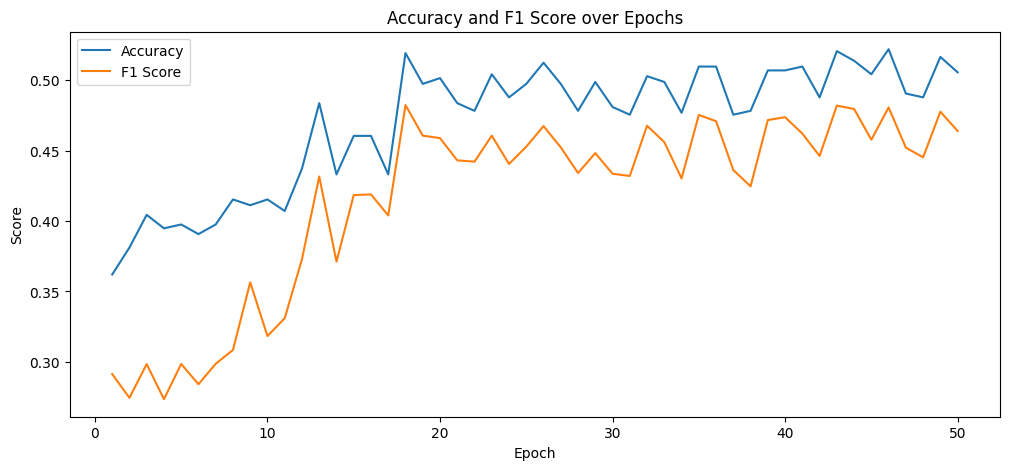

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot Accuracy and F1 Score over Epochs
plt.figure(figsize=(12, 5))
plt.plot(history_df['epoch'], history_df['accuracy'], label="Accuracy")
plt.plot(history_df['epoch'], history_df['f1_score'], label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy and F1 Score over Epochs")
plt.legend()
plt.show()

                precision    recall  f1-score     support
Certainly Fake   0.463415  0.131034  0.204301  145.000000
Probably Fake    0.480916  0.350000  0.405145  180.000000
Probably Real    0.496994  0.829431  0.621554  299.000000
Certainly Real   0.655738  0.370370  0.473373  108.000000
accuracy         0.505464  0.505464  0.505464    0.505464
macro avg        0.524266  0.420209  0.426093  732.000000
weighted avg     0.509810  0.505464  0.463823  732.000000


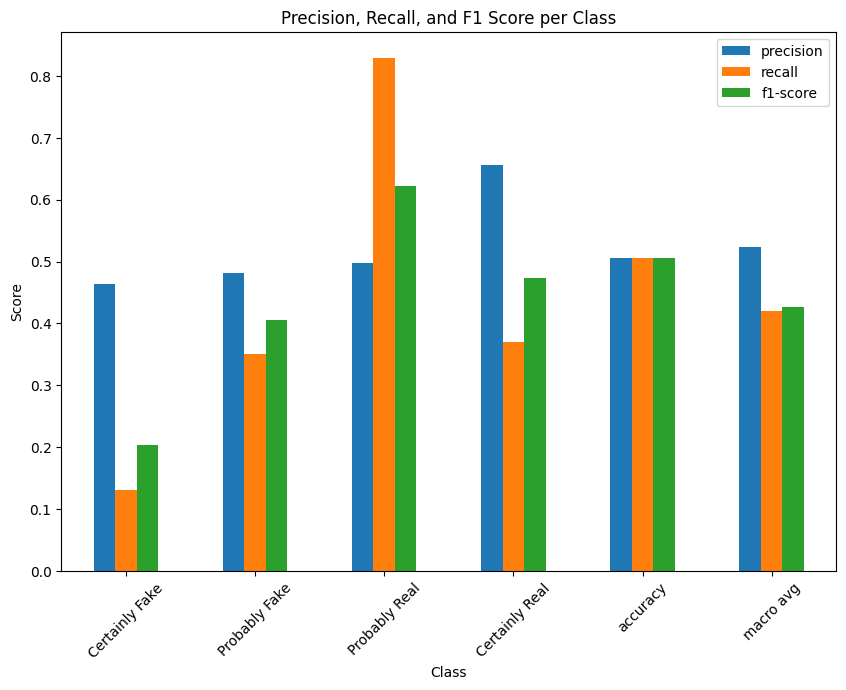

In [11]:
from sklearn.metrics import classification_report

# Assuming `all_labels` and `all_preds` contain labels and predictions for the last epoch
report = classification_report(all_labels, all_preds, target_names=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plot Precision, Recall, and F1 Score per Class
metrics = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude support and accuracy row
metrics.plot(kind='bar', figsize=(10, 7))
plt.title("Precision, Recall, and F1 Score per Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


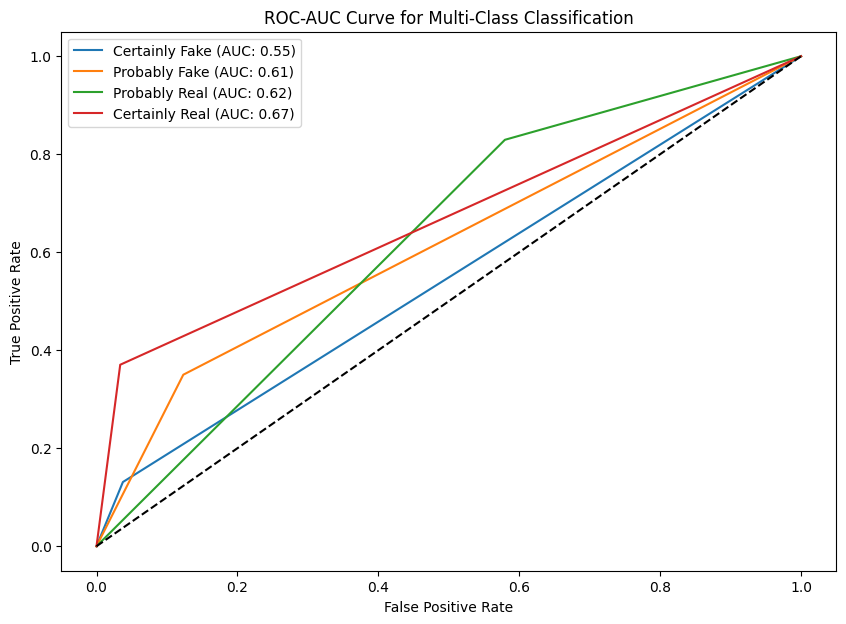

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for each class
classes = ["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"]
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3])
y_scores = label_binarize(all_preds, classes=[0, 1, 2, 3])

plt.figure(figsize=(10, 7))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC: {roc_auc_score(y_true[:, i], y_scores[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Multi-Class Classification")
plt.legend()
plt.show()
